# Time- and State-Dependent Resampling
This is the accompanying code to the Time- and State-Dependent Resampling article available at: https://ssrn.com/abstract=5117589

See also Chapter 3 in the Portfolio Construction and Risk Management book for additional details about the method and simulation: https://antonvorobets.substack.com/p/pcrm-book 

You can watch a video walkthrough of this example and its article here: https://youtu.be/AFGUaNG53A8 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import fortitudo.tech as ft
import matplotlib.pyplot as plt

# Load raw time series data and compute stationary transformations
Before generating the prior P&L simulation, we load the raw time series data and compute stationary transformations that are easier to project into the future (same as 7_RiskFactorViews)

In [2]:
# Load the simulated time series data
time_series = ft.load_time_series()

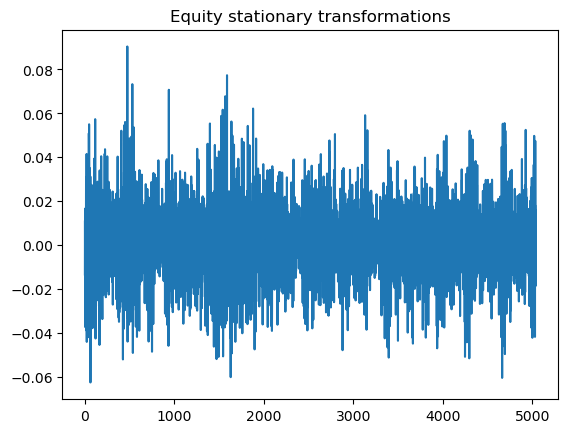

In [3]:
# Compute equity stationary transformations
eqt_log_chg = np.diff(np.log(time_series.iloc[:, 0]))
plt.plot(eqt_log_chg)
plt.title('Equity stationary transformations')
plt.show()

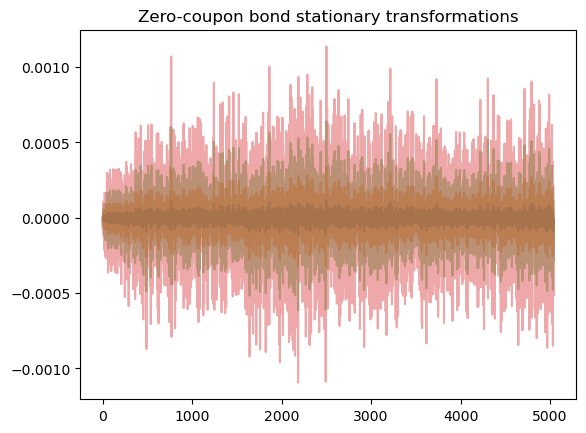

In [4]:
# Compute government bond stationary transformations
zcb_maturities = np.hstack((np.array([1/12, 1/4, 1/2]), np.arange(1, 31)))
zcb_df = np.exp(-time_series.iloc[:, 1:34] / 100 * zcb_maturities)
zcb_log_chg = np.diff(np.log(zcb_df), axis=0)
plt.plot(zcb_log_chg[:, [0, 1, 2, 3]], alpha=0.4)
plt.title('Zero-coupon bond stationary transformations')
plt.show()

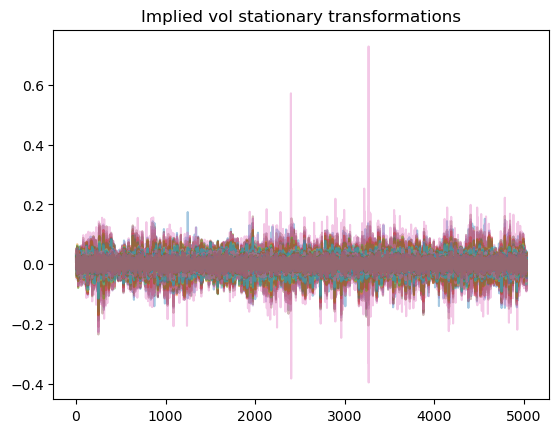

In [5]:
# Compute implied vol stationary transformations
vol_log_chg = np.diff(np.log(time_series.iloc[:, 34:69]), axis=0)
plt.plot(vol_log_chg, alpha=0.4)
plt.title('Implied vol stationary transformations')
plt.show()

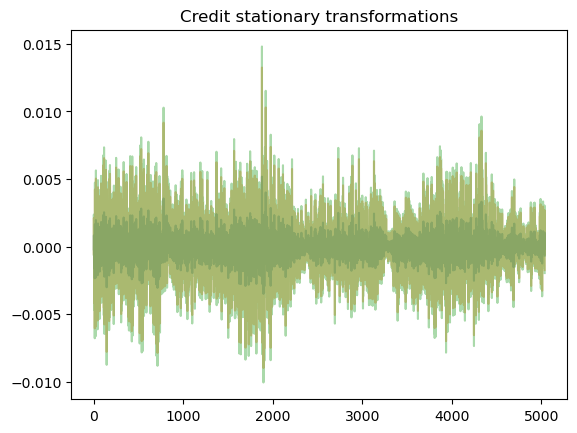

In [6]:
# Compute credit stationary transformations
cr_maturities = np.arange(1, 11)
cr_df = np.exp(-time_series.iloc[:, 69:] / 100 * cr_maturities)
cr_log_chg = np.diff(np.log(cr_df), axis=0)
plt.plot(cr_log_chg[:, [0, 4, 9]], alpha=0.4)
plt.title('Credit stationary transformations')
plt.show()

In [7]:
# Collect stationary transformations into one DataFrame
st_df = pd.DataFrame(
    np.hstack((eqt_log_chg[:, np.newaxis], zcb_log_chg, vol_log_chg, cr_log_chg)),
    columns=time_series.columns)

# Visualize implied vol state-conditioning

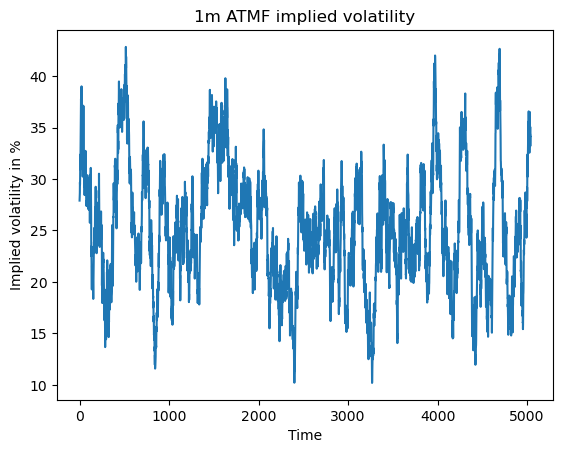

In [8]:
imp_vol_1m = time_series['1m100'].iloc[1:].values
plt.plot(imp_vol_1m)
plt.title('1m ATMF implied volatility')
plt.ylabel('Implied volatility in %')
plt.xlabel('Time')
plt.show()

In [9]:
# Compute percentiles and indices
imp_vol_25pct = np.percentile(imp_vol_1m, 25)
low_vol_indices = imp_vol_1m <= imp_vol_25pct
imp_vol_75pct = np.percentile(imp_vol_1m, 75)
mid_vol_indices = (imp_vol_1m < imp_vol_25pct) ^ (imp_vol_1m <= imp_vol_75pct)
high_vol_indices = imp_vol_1m > imp_vol_75pct

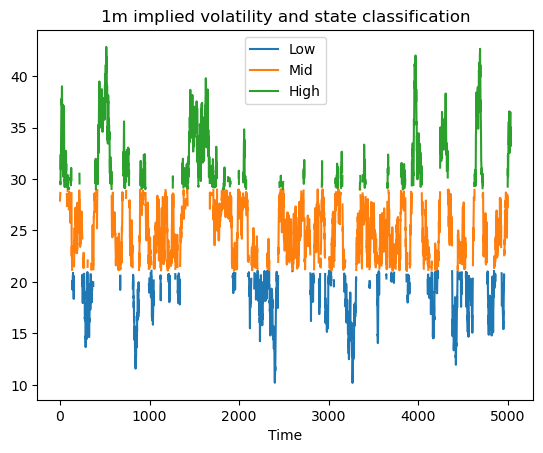

In [10]:
# Plot the 1m implied vol with state classification
vol_low = np.ma.masked_where(low_vol_indices == False, imp_vol_1m)
vol_mid = np.ma.masked_where(mid_vol_indices == False, imp_vol_1m)
vol_high = np.ma.masked_where(high_vol_indices == False, imp_vol_1m)
x = np.arange(0, len(imp_vol_1m))
plt.plot(x, vol_low, x, vol_mid, x, vol_high)
plt.xlabel('Time')
plt.legend(['Low', 'Mid', 'High'])
plt.title('1m implied volatility and state classification')
plt.show()

# Compute scenario probabilities for Fully Flexible Resampling

In [11]:
# Exponential decay prior
T_tilde = len(st_df)
p_exp = ft.exp_decay_probs(st_df, half_life=T_tilde / 2)

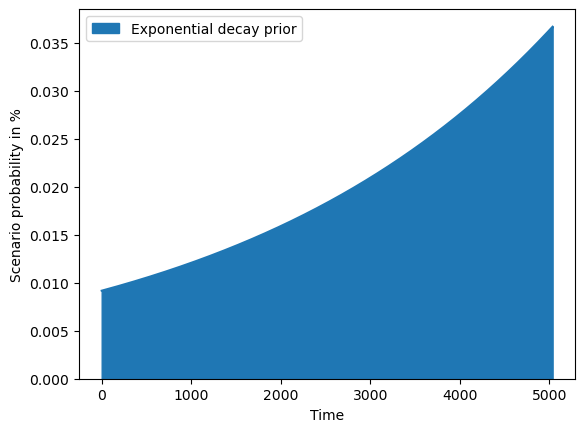

In [12]:
pd.DataFrame(100 * p_exp, columns=['Exponential decay prior']).plot(kind='area')
plt.ylabel('Scenario probability in %')
plt.xlabel('Time')
plt.show()

In [13]:
# Compute view values for Entropy Pooling views
mu_low = np.mean(imp_vol_1m[low_vol_indices])
sigma_low = np.std(imp_vol_1m[low_vol_indices])
mu_mid = np.mean(imp_vol_1m[mid_vol_indices])
sigma_mid = np.std(imp_vol_1m[mid_vol_indices])
mu_high = np.mean(imp_vol_1m[high_vol_indices])
sigma_high = np.std(imp_vol_1m[high_vol_indices])

In [14]:
# Specify left hand sides for Entropy Pooling views
A = np.vstack((np.ones((1, T_tilde)), imp_vol_1m))  # probabilities sum to 1 and mean
b_low = np.array(([[1.], [mu_low]]))
b_mid = np.array(([[1.], [mu_mid]]))
b_high = np.array(([[1.], [mu_high]]))
G = imp_vol_1m[:, np.newaxis].T ** 2
h_low = np.array([[sigma_low ** 2 + mu_low ** 2]])
h_mid = np.array([[sigma_mid ** 2 + mu_mid ** 2]])
h_high = np.array([[sigma_high ** 2 + mu_high ** 2]])

In [15]:
# Compute Fully Flexible Resampling probability vectors
q_low = ft.entropy_pooling(p_exp, A, b_low, G, h_low)
q_mid = ft.entropy_pooling(p_exp, A, b_mid, G, h_mid)
q_high = ft.entropy_pooling(p_exp, A, b_high, G, h_high)

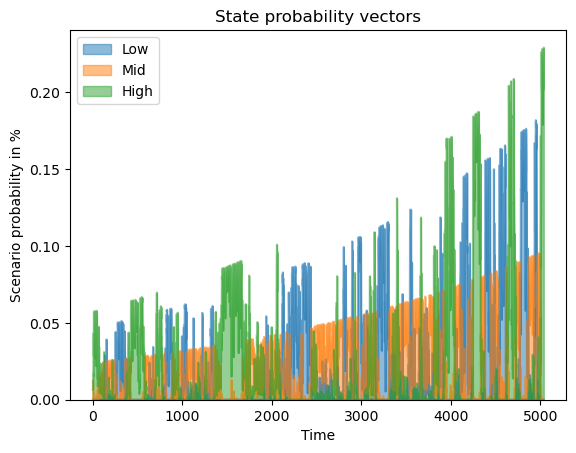

In [16]:
# Division by the sum to make the posterior probabilities sum to 1 exactly
states_prob = np.hstack((q_low / np.sum(q_low), q_mid / np.sum(q_mid), q_high / np.sum(q_high)))
pd.DataFrame(100 * states_prob, columns=['Low', 'Mid', 'High']).plot(kind='area', stacked=False)
plt.title('State probability vectors')
plt.xlabel('Time')
plt.ylabel('Scenario probability in %')
plt.show()

# Simulate

In [17]:
states_vector = 0 * low_vol_indices + 1 * mid_vol_indices + 2 * high_vol_indices

In [18]:
# Define a Fully Flexible Resampling function
def resampling(S, H, initial_state, states_prob, states_vector):
    sim = np.full((S, H), 1)
    t = np.arange(len(states_vector))
    for s in range(S):
        current_state = initial_state
        for h in range(H):
            sim[s, h] = np.random.choice(t, p=states_prob[:, current_state])
            current_state = states_vector[sim[s, h]]
    return sim

In [19]:
# Simulate historical observations
S = 10000
H = 21
np.random.seed(1)
sim0 = resampling(S, H, 0, states_prob, states_vector)
sim1 = resampling(S, H, 1, states_prob, states_vector)
sim2 = resampling(S, H, 2, states_prob, states_vector)

In [20]:
# Extract equity stationary transformations and compute returns
equity_low = np.full((S, H), np.nan)
equity_mid = np.full((S, H), np.nan)
equity_high = np.full((S, H), np.nan)

for s in range(S):
    equity_low[s, :] = st_df.values[sim0[s, :], 0]
    equity_mid[s, :] = st_df.values[sim1[s, :], 0]
    equity_high[s, :] = st_df.values[sim2[s, :], 0]

return_low = np.exp(np.cumsum(equity_low, axis=1)) - 1
return_mid = np.exp(np.cumsum(equity_mid, axis=1)) - 1
return_high = np.exp(np.cumsum(equity_high, axis=1)) - 1

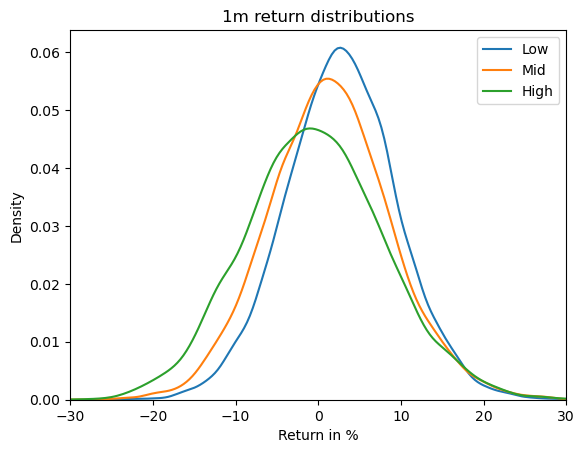

In [21]:
sns.kdeplot(100 * return_low[:, -1])
sns.kdeplot(100 * return_mid[:, -1])
sns.kdeplot(100 * return_high[:, -1])
plt.legend(['Low', 'Mid', 'High'])
plt.title('1m return distributions')
plt.xlim([-30, 30])
plt.xlabel('Return in %')
plt.show()

# Compute state probability transition matrix

In [22]:
num_states = states_prob.shape[1]
transition_matrix = np.full((num_states, num_states), np.nan)
states = np.unique(states_vector)

for row_state in states:
    for col_state in states:
        transition_matrix[row_state, col_state] = np.sum(states_prob[states_vector == col_state, row_state])

In [23]:
# Print transition matrix
pd.DataFrame(np.round(100 * transition_matrix, 4))

,0,1,2
0,90.2155,9.7843,0.0001
1,4.2097,92.3830,3.4073
2,0.0055,10.6188,89.3757


In [24]:
# fortitudo.tech - Novel Investment Technologies.
# Copyright (C) 2021-2025 Fortitudo Technologies.

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.